## Stock Prices

We'll begin by loading the `pandas_datareader` module for access to convenient APIs, and the `datetime` module to specify start and end dates of data that we want to pull.

There are multiple options in the `pandas_datareader` module for collecting stock price data.  Some reliable data providers are:
1. Tiingo
2. IEX
3. AlphaVantage

These three sources require API keys to access their data.  An alternative option is to use Yahoo Finance, which also has an API via `pandas_datareader`.  You can use Yahoo without an API key because `pandas_datareader` will pull data from Yahoo not via a computer-friendly API system but rather by scraping information off of the Yahoo site.  If the page gets re-designed, this method will fail until the `pandas_datareader` module updates to address the change.  Yahoo data has some reliability issues (the prices are inaccurate), and it is not recommended to use Yahoo data for any kind of important analysis.

In [1]:
import pandas_datareader.data as web
from datetime import datetime

The API that we will make use of today is from [Alpha Vantage](https://www.alphavantage.co/support/#api-key).  Click the link to their website to request a free key.  Limits on free API users at the time of writing this notebook include:
- no more than 5 API requests per minute
- no more than 500 API requests per day

Premium memberships allow for more access to the data.  For our purposes, the free key is sufficient.

Run the following code cell to `pickle` your key, filling in the value for `api_key` as appropriate, using the key that you receive from the Alpha Vantage website.  If you want, you may delete this cell from your notebook after successfully pickling your key.

In [0]:
import pickle
api_key = 'YOUR KEY HERE'
with open('../pickle_jar/av_key.p', 'wb') as f:
    pickle.dump(api_key, f)

With your key pickled, you can now load it as follows:

In [3]:
import pickle
with open('../pickle_jar/av_key.p', 'rb') as f:
    api_key = pickle.load(f)
print(api_key[0:3])

VAS


Let's start by investigating VISA's stock price in 2015.  Begin by specifying start and end dates as `datetime` dates, as we did in the previous chapter.  To access daily data from Alpha Vantage, we use `av-daily-adjusted` as our source.  Unlike in the previous chapter, we now need to use an `api_key` argument in the `DataReader()` function.  Using this key allows for Alpha Vantage to impose rate limits on free accounts.

In [5]:
start = datetime(2015, 1, 1)
end = datetime(2015, 12, 31)

visa = web.DataReader('V', 'av-daily-adjusted', start, end, api_key=api_key)

To see a snapshot of this data, let's print the head.

In [6]:
visa.head()

,open,high,low,close,adjusted close,volume,dividend amount,split coefficient
2015-01-02,263.38,266.7500,262.4900,265.02,63.342410,2098520,0.0,1.0
2015-01-05,263.49,263.4999,258.8652,259.17,61.944202,3187800,0.0,1.0
2015-01-06,259.79,260.7800,254.8550,257.50,61.545055,2767523,0.0,1.0
2015-01-07,258.44,261.1400,257.4500,260.95,62.369639,2336705,0.0,1.0
2015-01-08,263.20,265.1200,262.6300,264.45,63.206174,2610864,0.0,1.0


The term's `'close'` and `'adjusted close'` may or may not be new to you.  To see the utility of the `'adjusted close'` data, we'll begin by plotting the closing stock price for VISA, as reported in the `'close'` column.

<AxesSubplot:>

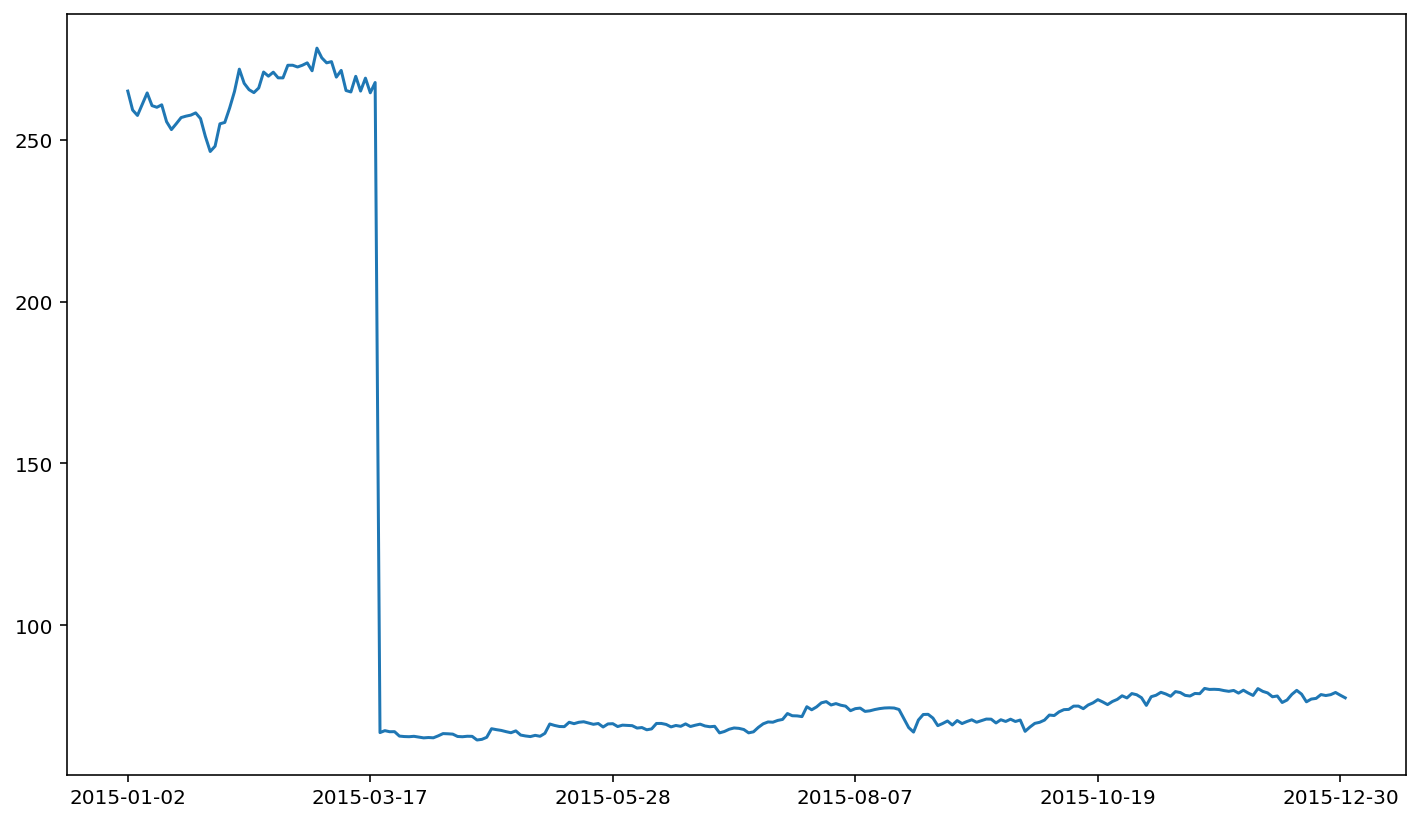

In [7]:
visa['close'].plot()

Yikes!  There's quite a crash in March of 2015.  The crash in the closing stock price for VISA corresponds to a stock split.  If you don't adjust your data for stock splits, stock returns based on these underlying prices will have ridiculous outliers in the data series.  This is important because this erroneous data will adversely affect the quality of your statistical analysis.  For this reason, stock price analysis relies on *split-adjusted* data.  The Alpha Vantage adjusted closing price is a price series that takes in to account splits (following the standard CRSP methodology).  The adjusted close price does not demonstrate a similar crash.

<AxesSubplot:>

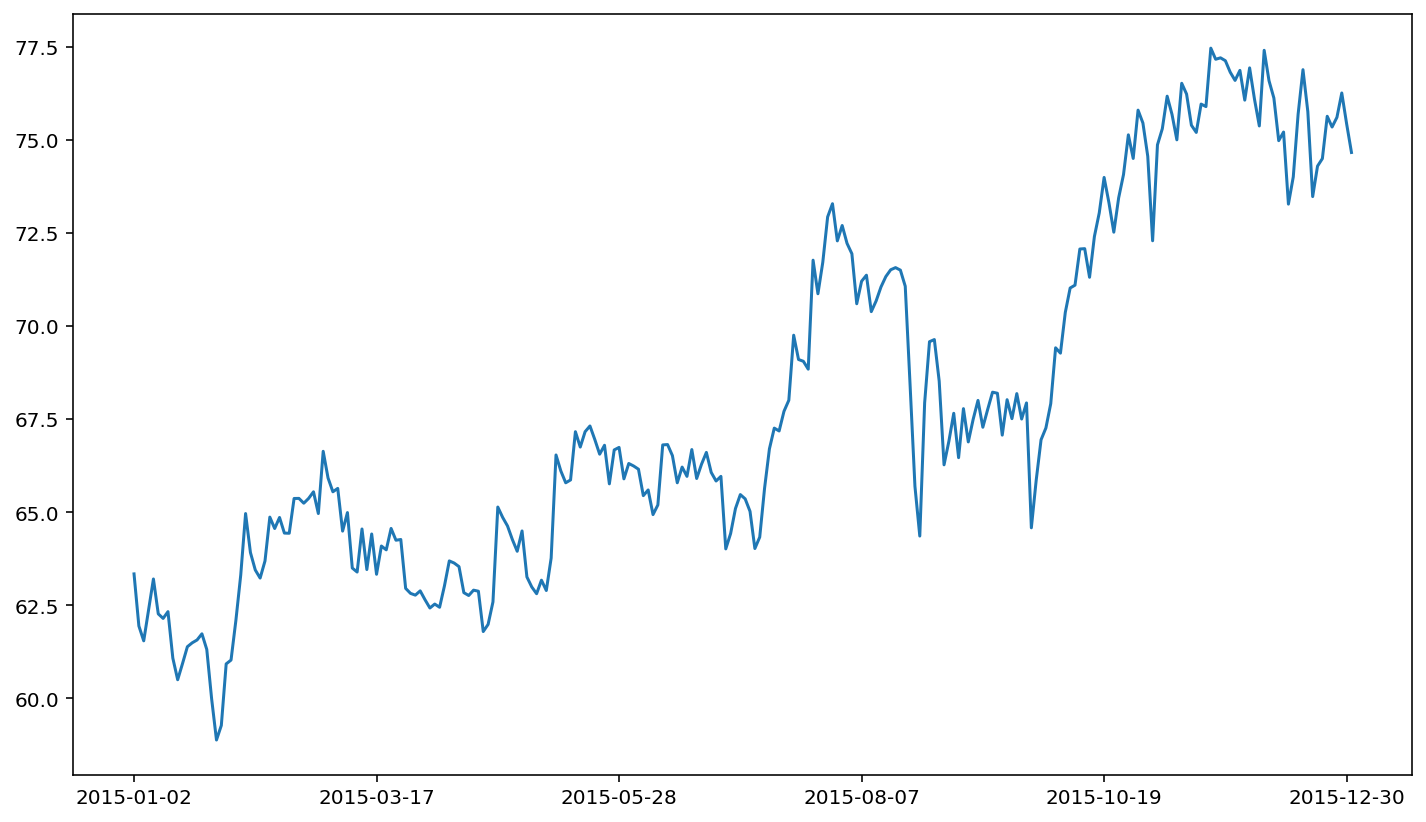

In [8]:
visa['adjusted close'].plot()

Let's now pull data for four different companies, using a longer series of data.  Our interest here will be in the FANG stocks: Facebook, Amazon, Netflix, Google.  Each data series will be a new API call to Alpha Vantage.

In [9]:
end = datetime(2019, 12, 31)

fb = web.DataReader('FB', 'av-daily-adjusted', start, end, api_key=api_key)
amzn = web.DataReader('AMZN', 'av-daily-adjusted', start, end, api_key=api_key)
nflx = web.DataReader('NFLX', 'av-daily-adjusted', start, end, api_key=api_key)
goog = web.DataReader('GOOG', 'av-daily-adjusted', start, end, api_key=api_key)

The four DataFrames that we create above can be used just like in the case of VISA.  For example:

<AxesSubplot:>

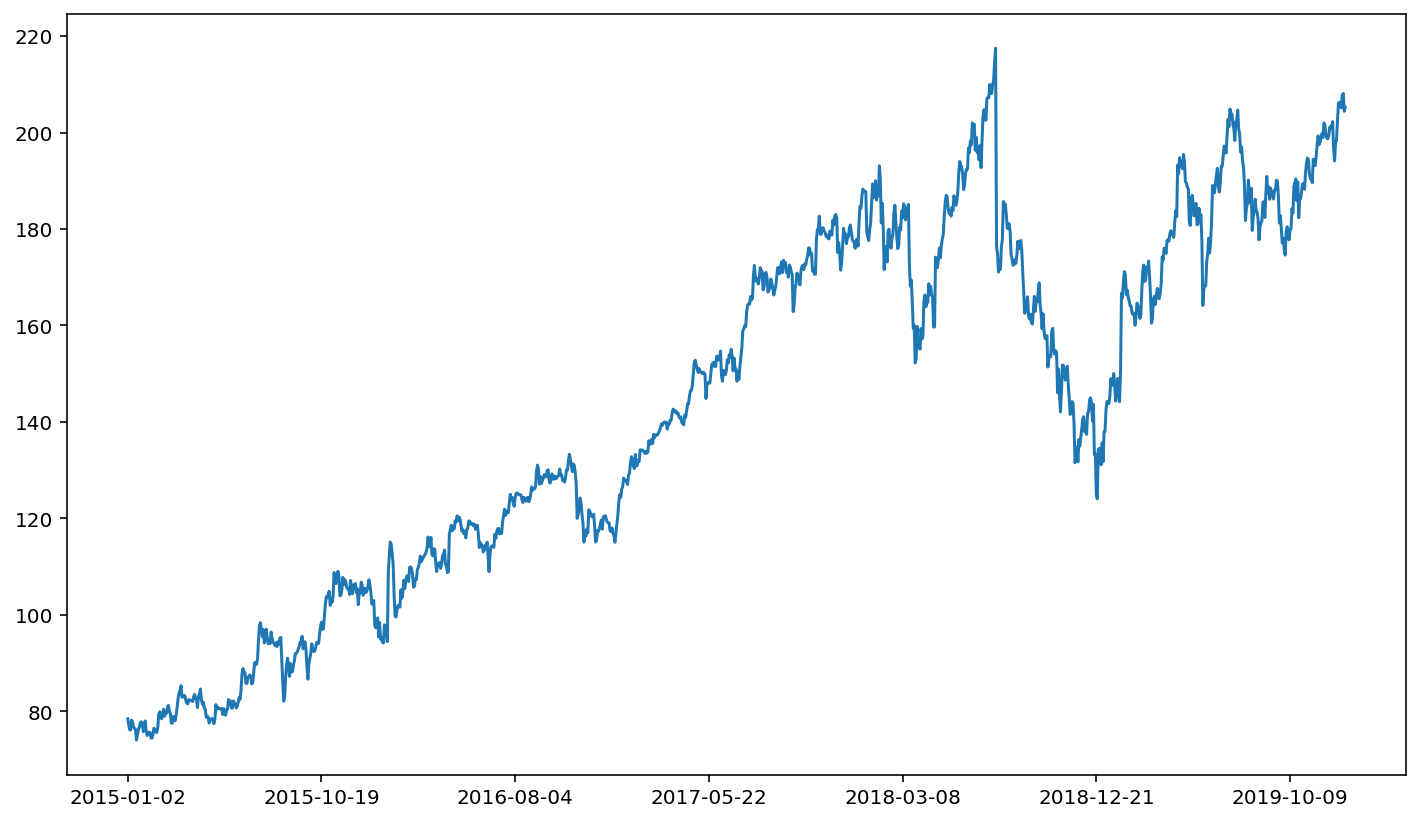

In [10]:
fb['adjusted close'].plot()

One trick with comparing prices across companies is that we need to *normalize* the price.  The price of a share of stock in a company will depend on the value of the company and the number of shares being traded.  Thus, it's not an apples to apples comparison to look at stock price movements for two different companies with vastly different stock prices.  In fact, it's sometimes difficult to even visualize two different price series if the two price series are of vastly different magnitudes.  For example:

<AxesSubplot:>

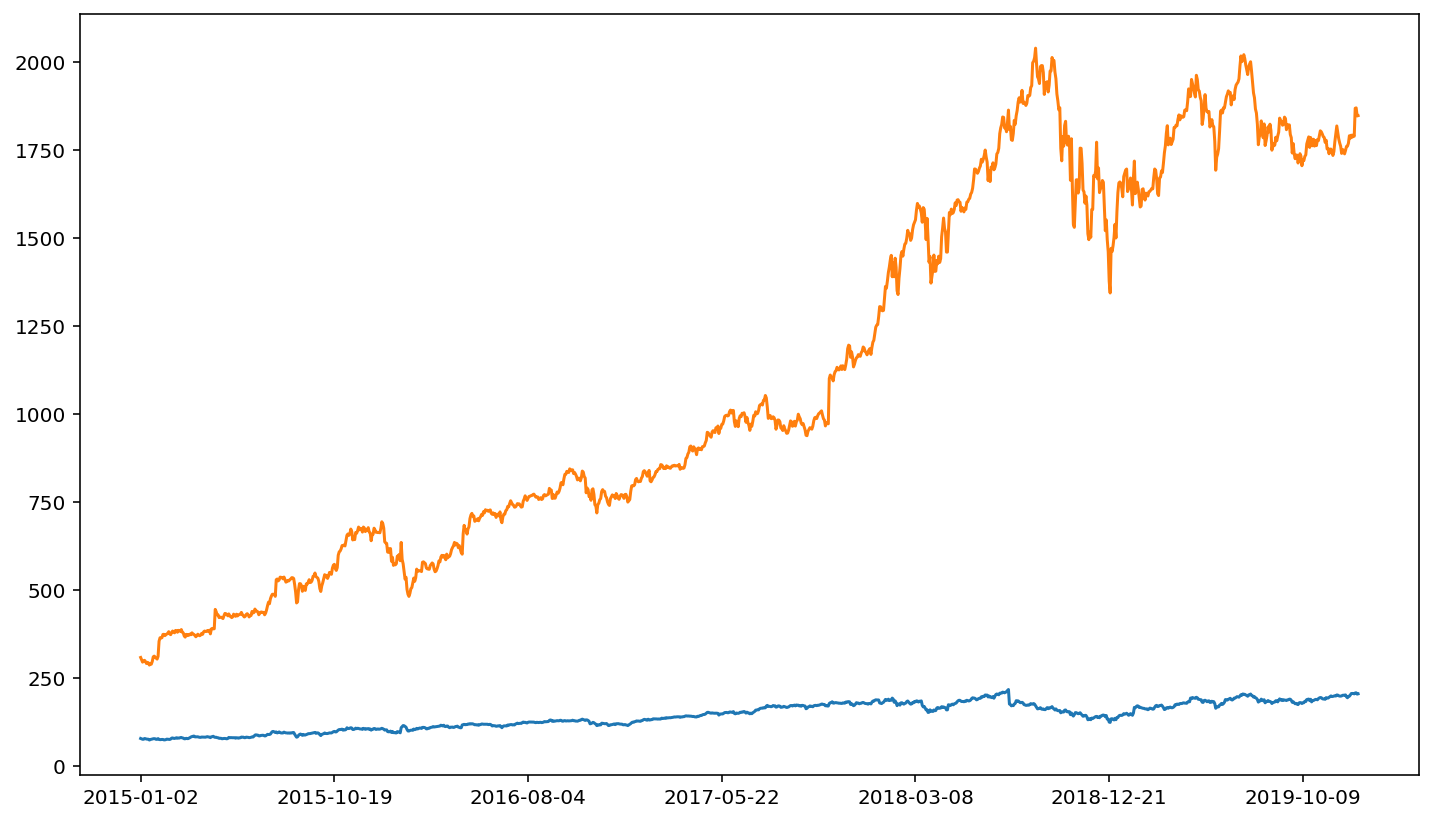

In [11]:
fb['adjusted close'].plot()
amzn['adjusted close'].plot()

The relative magnitude of FB versus AMZN makes it hard to visualize price movements for AMZN when FB is plotted in the same figure.

Thus, we divide prices by the starting price (the price at the start of our data series).  This will scale the prices for all companies in the data so that their movements are more comparable.

Because `fb['adjusted close']` corresponds to one series (one column) of data, we can use `fb['adjusted close'].iloc[0]` to get the first element of that series.

<AxesSubplot:>

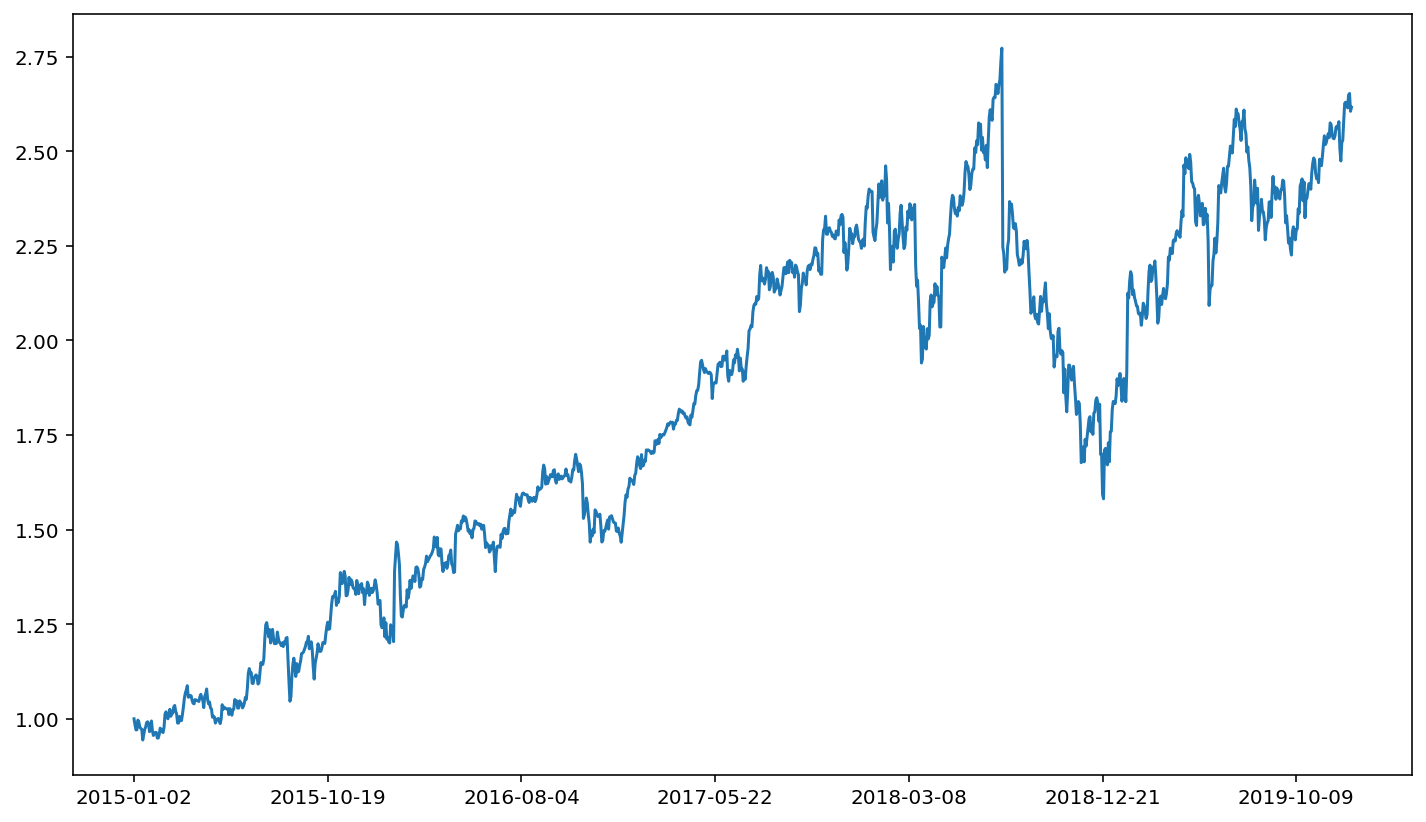

In [12]:
fb['ret'] = fb['adjusted close'] / fb['adjusted close'].iloc[0]
fb['ret'].plot()

Compared to our earlier plot of FB's stock movement, the information is the same.  That is, the ups and downs look identical.  Note, however, that the scale on the y axis has changed.  This makes comparison more straight forward.

<AxesSubplot:>

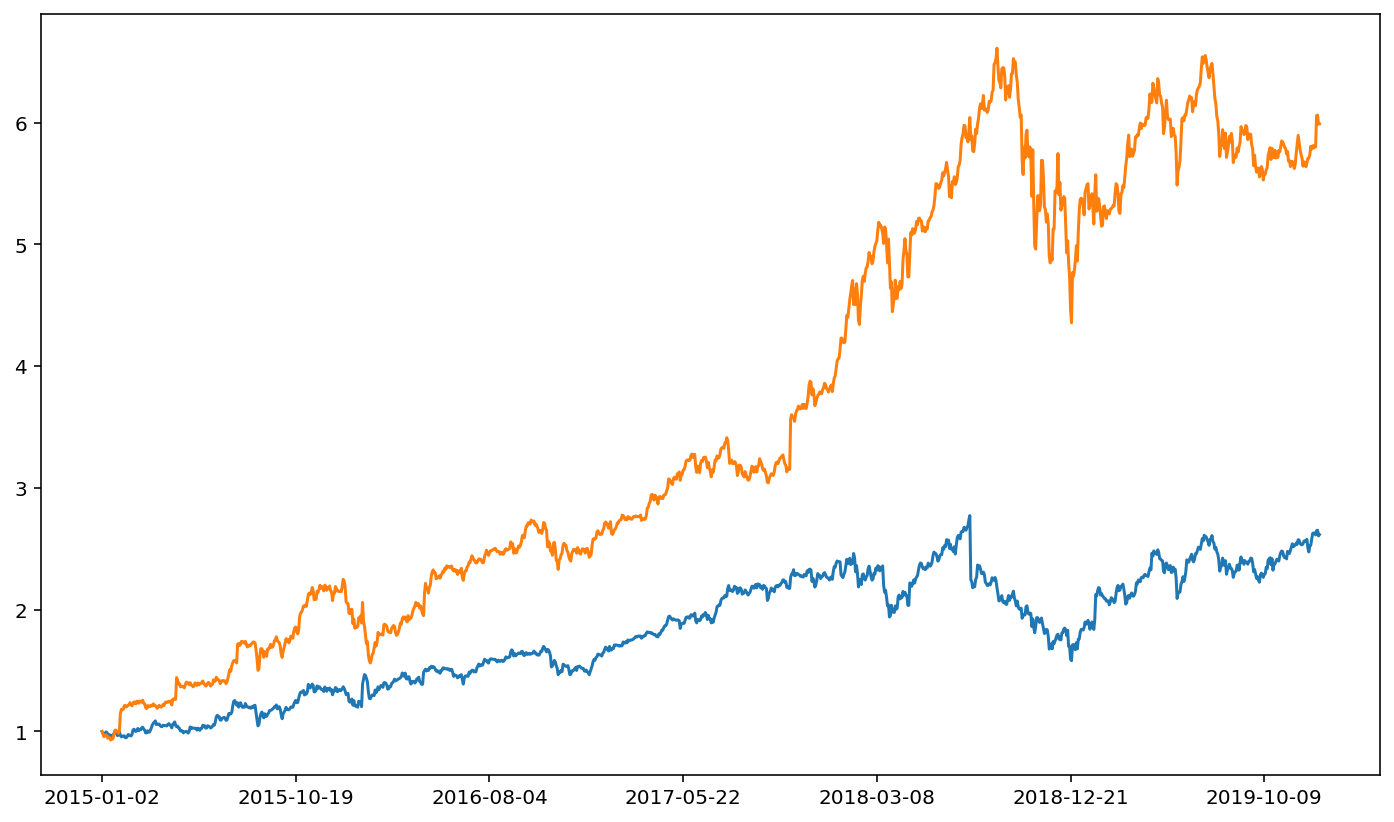

In [14]:
amzn['ret'] = amzn['adjusted close'] / amzn['adjusted close'].iloc[0]

fb['ret'].plot()
amzn['ret'].plot()

Every stock here has its own DataFrame.  That can become a lot of information to keep track of.  One common trick to deal with all of these DataFrames is to pack them in to a dictionary.  Here, the *key* of the dictionary is the stock name (the ticker symbol).  The *value* of the dictionary is the corresponding DataFrame of data for the relevant ticker.

In [15]:
fang = {'FB':fb, 'AMZN':amzn, 'NFLX':nflx, 'GOOG':goog}

We can thus reference a DataFrame implicitly.  Rather than referring to it's name directly (e.g. `fb`), we can get it indirectly via the dictionary (e.g. `fang['fb']`).  Thus, we can re-create the above plot with:

<AxesSubplot:>

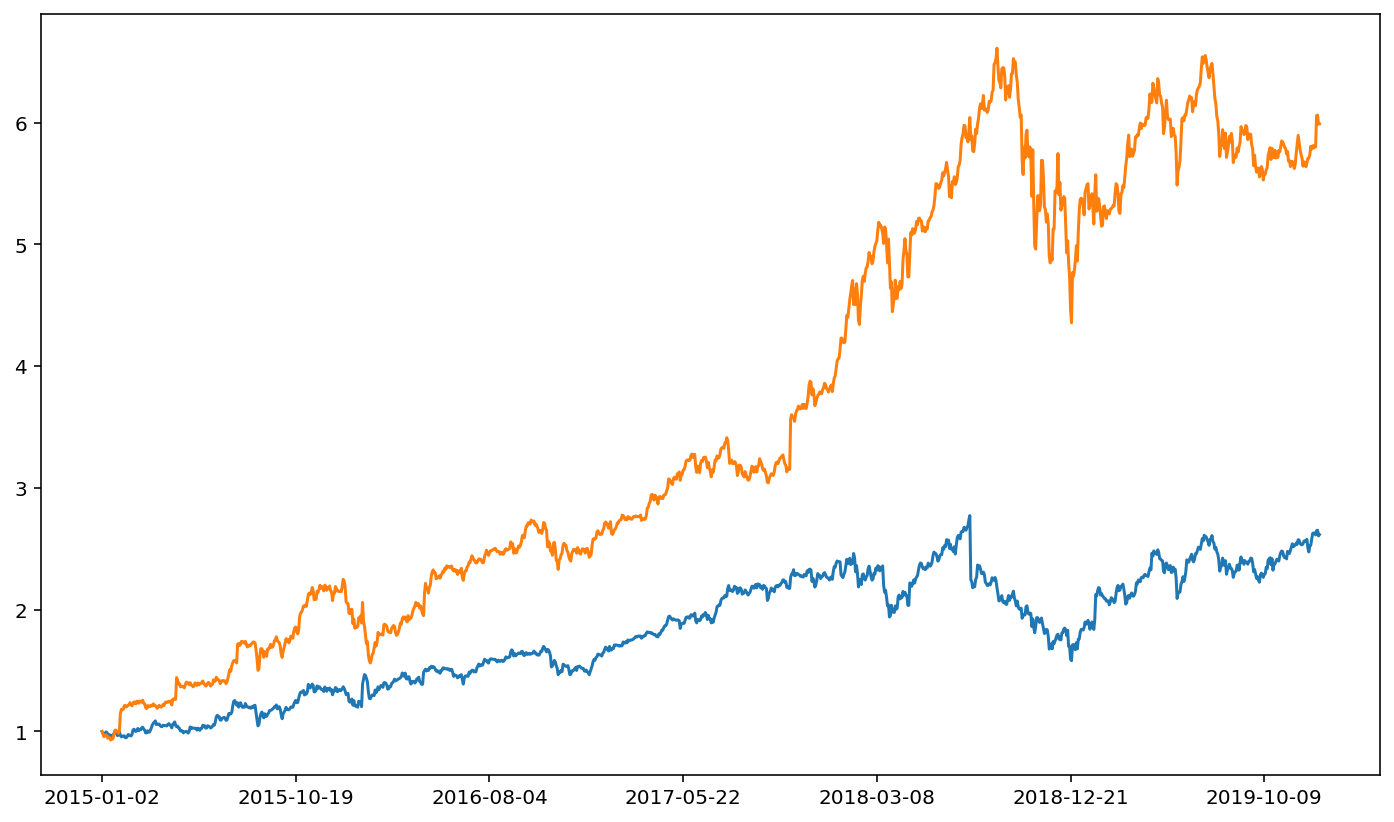

In [16]:
fang['FB']['ret'].plot()
fang['AMZN']['ret'].plot()

At first glance, this may seem more cumbersome than the original method.  Note, however, that packing DataFrames in to dictionaries is a *huge* time saver.  This is because it allows us to more quickly modify values for all DataFrames.  Note that we can get the keys of a dictionary via `.keys()`.

In [17]:
fang.keys()

dict_keys(['FB', 'AMZN', 'NFLX', 'GOOG'])

This is convenient because we can then loop over a list of keys.  By doing so, we can modify *every* DataFrame in our dictionary with a simple `for` loop.  Implicitly referencing DataFrames based on a dictionary key-value relationship can be much more efficient than explicitly referencing each DataFrame by name.

In [18]:
for tic in fang.keys():
    fang[tic]['ret'] = fang[tic]['adjusted close'] / fang[tic]['adjusted close'].iloc[0]

Having normalized prices for all DataFrames, we can now plot the four FANG stocks.

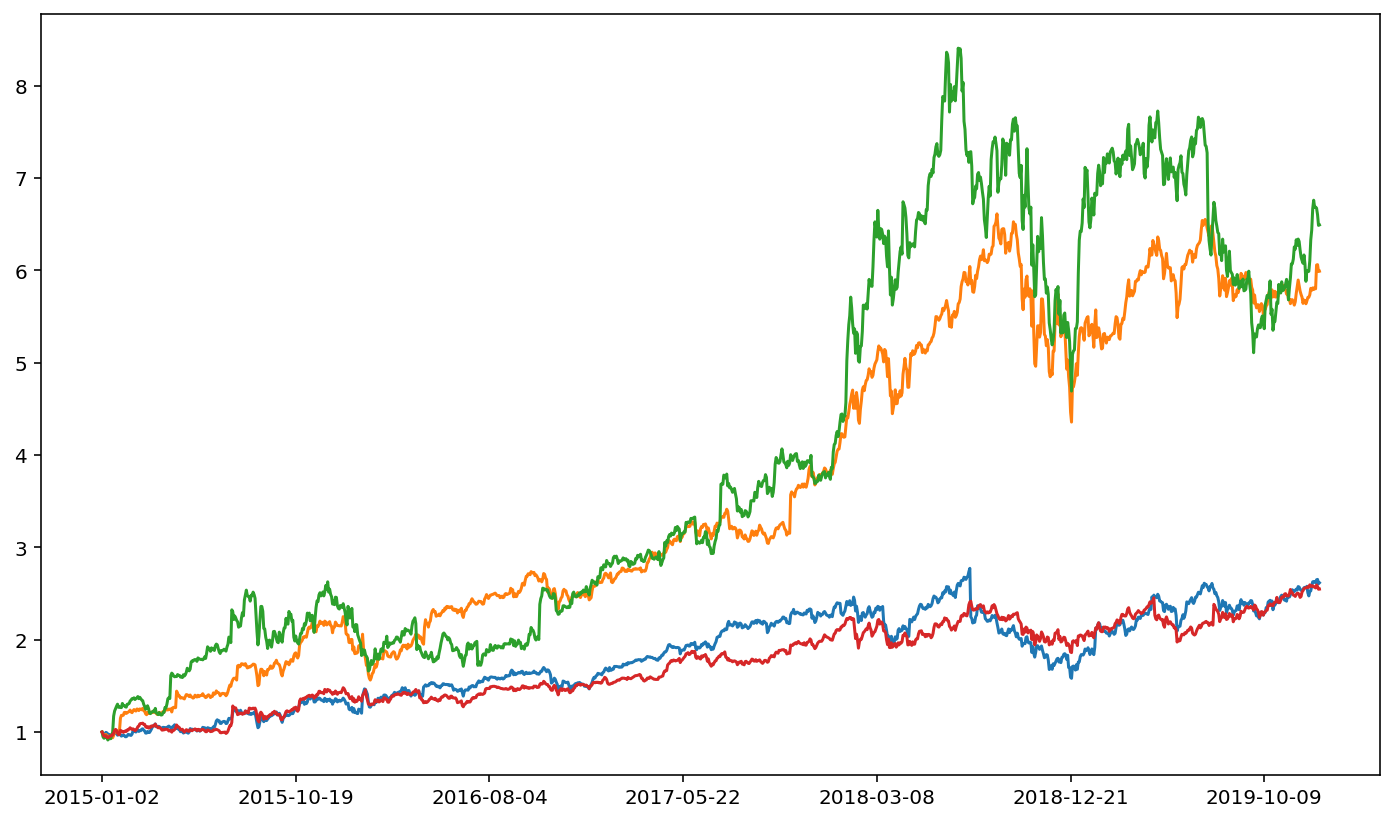

In [19]:
for tic in fang.keys():
    fang[tic]['ret'].plot()

It's not immediately clear from the figure who the standout stock is.  That is, the stock that grew much more than the others over this sample period.  The easiest way is to simply print out the ending value for each series.  Note that just as we can type `.iloc[0]` to get the first element of a series, we can type `.iloc[-1]` to get the *last* element of the series (and, similarly, the second to last element is `.iloc[-2]`).

In [20]:
for tic in fang.keys():
    print(tic)
    print(fang[tic]['ret'].iloc[-1])

FB
2.6163161249203313
AMZN
5.989368598470115
NFLX
6.4910651257874274
GOOG
2.5476267601608202


The standout stock is thus NFLX.

Now, suppose we want to combine all these return series in to one DataFrame.  That will simplify some later analysis for us.  Besides, once we get returns, we generally don't do much with the other columns of data (e.g. opening price or volume).

As a preliminary step towards combining data together, we need to name the returns for each DataFrame something distinct.  Recall that we can combine strings together with '`+`', as in `'cat'+'dog'` equals `'catdog'` (note the lack of space).

In [21]:
for tic in fang.keys():
    print(tic + ' ret')

FB ret
AMZN ret
NFLX ret
GOOG ret


Rather than name the return series `'ret'` for each DataFrame, we'll name it `tic+' ret'`, where `tic` holds the dictionary key that we're working with.  Hence, the return series for FB would be named `'FB ret'`.

In [22]:
for tic in fang.keys():
    fang[tic][tic + ' ret'] = fang[tic]['adjusted close'] / fang[tic]['adjusted close'].iloc[0]

In [23]:
fang['FB'].head()

,open,high,low,close,adjusted close,volume,dividend amount,split coefficient,ret,FB ret
2015-01-02,78.58,78.9300,77.700,78.450,78.450,18177475,0.0,1.0,1.000000,1.000000
2015-01-05,77.98,79.2455,76.860,77.190,77.190,26452191,0.0,1.0,0.983939,0.983939
2015-01-06,77.23,77.5900,75.365,76.150,76.150,27399288,0.0,1.0,0.970682,0.970682
2015-01-07,76.76,77.3600,75.820,76.150,76.150,22045333,0.0,1.0,0.970682,0.970682
2015-01-08,76.74,78.2300,76.080,78.175,78.175,23960953,0.0,1.0,0.996495,0.996495


With that done, we can now subset our data to only include this named return series (e.g. `'FB ret'`, `'AAPL ret'`, etc.).  All other columns will be removed.

In [24]:
for tic in fang.keys():
    fang[tic] = fang[tic][[tic + ' ret']].copy()

In [25]:
fang['FB'].head()

,FB ret
2015-01-02,1.000000
2015-01-05,0.983939
2015-01-06,0.970682
2015-01-07,0.970682
2015-01-08,0.996495


Here, we have four DataFrames that we want to combine.  The `.merge()` function used previously can link together two DataFrames, but not more than two.  To handle a merger between four DataFrames, we need to use `.join()`.  The syntax for merging two DataFrames with `.merge()` is `df1.merge(df2)`, where `df1` and `df2` are DataFrames.  We can likewise do `df1.join(df2)` to merge via `.join()`.  More useful, however, is the fact that we can do `df1.join([df2,df3,df4])` to combine four DataFrames all at once.  Thus, we need two items.  First, we need a `df1`; we'll use FB for this.  Second, we need a list `[df2, df3, df4]`.  We'll use AAPL, NFLX, and GOOGL here.

In [26]:
F_value = fang['FB']
ANG_value = [fang[tic] for tic in ['AMZN', 'NFLX', 'GOOG']]

In [27]:
F_value

,FB ret
2015-01-02,1.000000
2015-01-05,0.983939
2015-01-06,0.970682
2015-01-07,0.970682
2015-01-08,0.996495
...,...
2019-12-24,2.614659
2019-12-26,2.648693
2019-12-27,2.652645
2019-12-30,2.605609


In [28]:
ANG_value

[            AMZN ret
 2015-01-02  1.000000
 2015-01-05  0.979483
 2015-01-06  0.957118
 2015-01-07  0.967263
 2015-01-08  0.973875
 ...              ...
 2019-12-24  5.799332
 2019-12-26  6.057209
 2019-12-27  6.060547
 2019-12-30  5.986289
 2019-12-31  5.989369
 
 [1258 rows x 1 columns],
             NFLX ret
 2015-01-02  1.000000
 2015-01-05  0.949103
 2015-01-06  0.932854
 2015-01-07  0.937697
 2015-01-08  0.958489
 ...              ...
 2019-12-24  6.684250
 2019-12-26  6.672816
 2019-12-27  6.601801
 2019-12-30  6.485849
 2019-12-31  6.491065
 
 [1258 rows x 1 columns],
             GOOG ret
 2015-01-02  1.000000
 2015-01-05  0.979154
 2015-01-06  0.956460
 2015-01-07  0.954822
 2015-01-08  0.957832
 ...              ...
 2019-12-24  2.560088
 2019-12-26  2.592176
 2019-12-27  2.575961
 2019-12-30  2.545950
 2019-12-31  2.547627
 
 [1258 rows x 1 columns]]

Thus, we can now create a DataFrame that joins together all four single-stock DataFrames.

In [29]:
df = F_value.join(ANG_value)
df.head()

,FB ret,AMZN ret,NFLX ret,GOOG ret
2015-01-02,1.000000,1.000000,1.000000,1.000000
2015-01-05,0.983939,0.979483,0.949103,0.979154
2015-01-06,0.970682,0.957118,0.932854,0.956460
2015-01-07,0.970682,0.967263,0.937697,0.954822
2015-01-08,0.996495,0.973875,0.958489,0.957832


Having all data in one DataFrame is powerful.  For instance, suppose that we want to create an equal-weighted portfolio of these four stocks.  An equal-weighted portfolio is achieved by allocating 1/4 weight to each stock, which is equivalent to adding up the returns for all four stocks and then dividing by four.  We can add across rows via `.sum(axis=1)`, where the `axis=1` argument tells `pandas` to sum by rows (rather than summing by column, which happens via `axis=0`).

In [30]:
df['ret'] = df[['FB ret', 'AMZN ret', 'NFLX ret', 'GOOG ret']].sum(axis=1) / 4
df.head()

,FB ret,AMZN ret,NFLX ret,GOOG ret,ret
2015-01-02,1.000000,1.000000,1.000000,1.000000,1.000000
2015-01-05,0.983939,0.979483,0.949103,0.979154,0.972920
2015-01-06,0.970682,0.957118,0.932854,0.956460,0.954279
2015-01-07,0.970682,0.967263,0.937697,0.954822,0.957616
2015-01-08,0.996495,0.973875,0.958489,0.957832,0.971673


Plotting is also more convenient when the data come from a single DataFrame.  Each series name is added to the plot legend so that it's easy to determine which stock is which.

<AxesSubplot:>

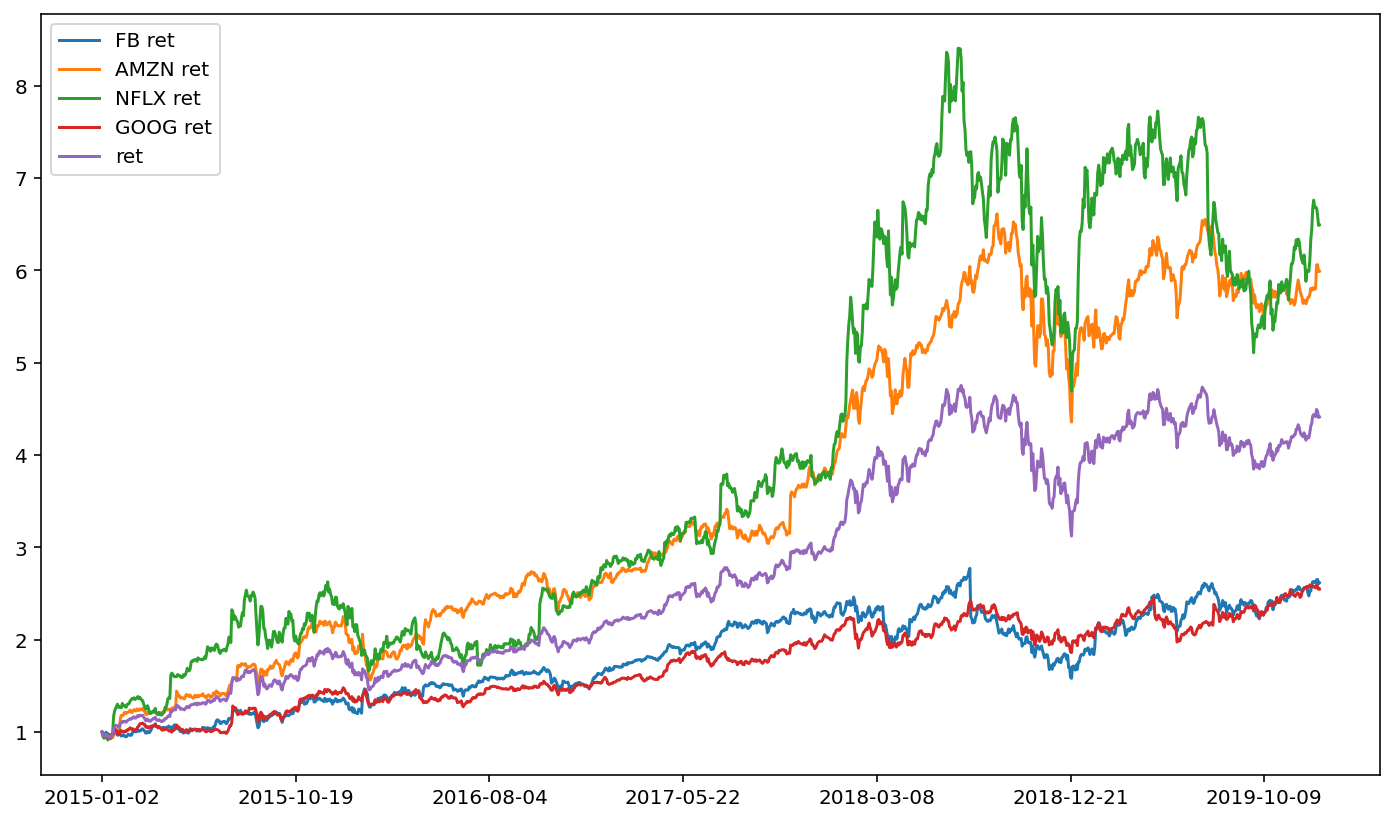

In [31]:
df.plot()

This portfolio perhaps doesn't give fantastic diversification benefits.  The four FANG stocks have similar ups and downs, and consequently our equal-weighted portfolio also follows those ups and downs.

One way to think about diversification is through return correlation.  Use the `.pct_change()` function to quickly get stock returns (percent changes in price).

In [32]:
pct_chng = df.pct_change()
pct_chng.head()

,FB ret,AMZN ret,NFLX ret,GOOG ret,ret
2015-01-02,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.016061,-0.020517,-0.050897,-0.020846,-0.027080
2015-01-06,-0.013473,-0.022833,-0.017121,-0.023177,-0.019160
2015-01-07,0.000000,0.010600,0.005192,-0.001713,0.003497
2015-01-08,0.026592,0.006836,0.022173,0.003153,0.014679


The `.std()` function will then yield a volatility estimate for each stock.  Note that this is a daily volatility since we are using daily stock returns.  We can convert this to an annual volatility by multiplying by $\sqrt{252}$.

In [33]:
import numpy as np
vol = pct_chng.std() * np.sqrt(252)
print(vol)

FB ret      0.282214
AMZN ret    0.292495
NFLX ret    0.416745
GOOG ret    0.240093
ret         0.261443
dtype: float64


Here, we observe that, while NFLX definitely grew the most over the period, it had the highest volatility.

The correlation matrix via `.corr()` will print out a correlation in returns.

In [36]:
pct_chng.corr()

,FB ret,AMZN ret,NFLX ret,GOOG ret,ret
FB ret,1.000000,0.569323,0.405252,0.599273,0.698254
AMZN ret,0.569323,1.000000,0.482377,0.641027,0.817429
NFLX ret,0.405252,0.482377,1.000000,0.466525,0.854580
GOOG ret,0.599273,0.641027,0.466525,1.000000,0.745282
ret,0.698254,0.817429,0.854580,0.745282,1.000000


As usual, `seaborn` will make things a little more aesthetically pleasing.  Correlation matrices can be difficult to digest, because it's just a big matrix of numbers.  The `.heatmap()` from `seaborn` will colorize the correlation matrix to make it easier to explore.

<AxesSubplot:>

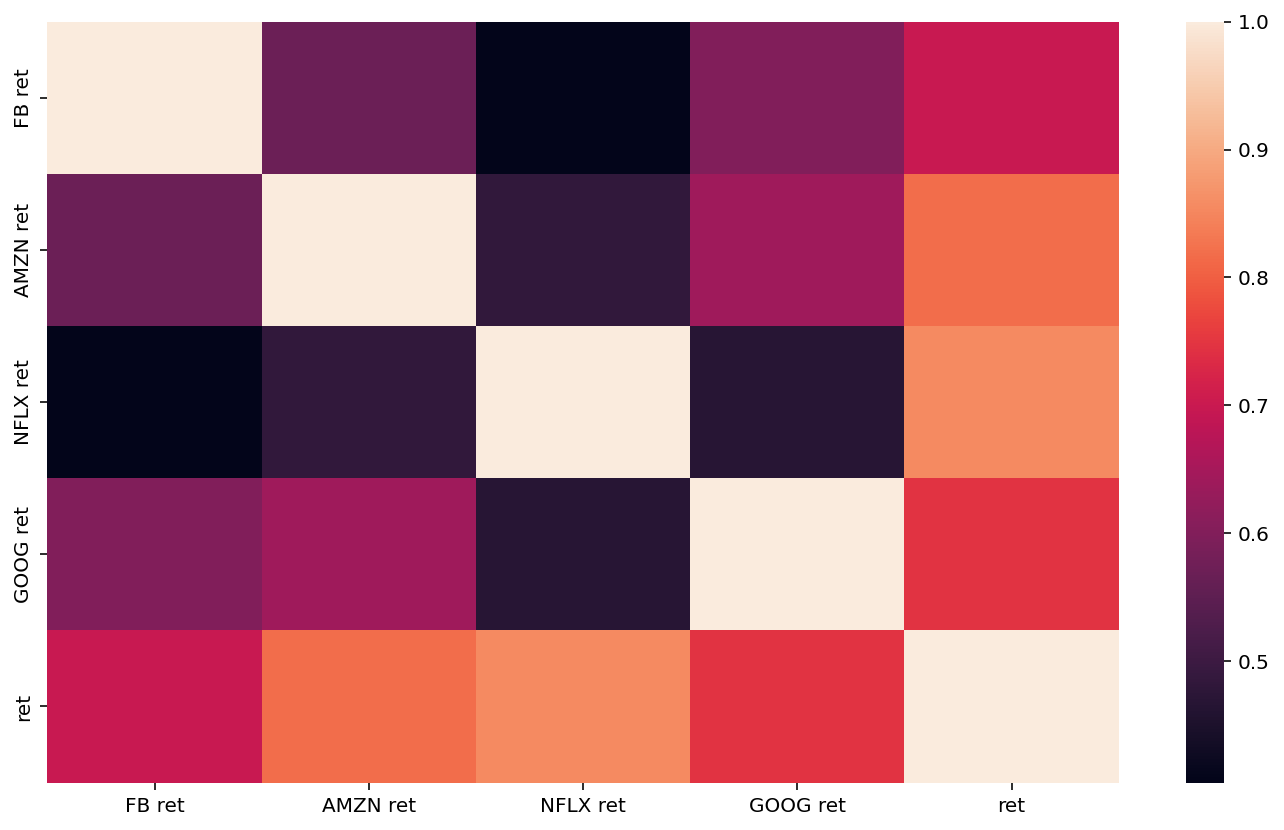

In [35]:
import seaborn as sns
sns.heatmap(pct_chng.corr())

Let's finish with another example.  Consider three cellular providers.  The `pandas_datareader` module makes it phenomenally easy to construct a portfolio of these companies.

<AxesSubplot:>

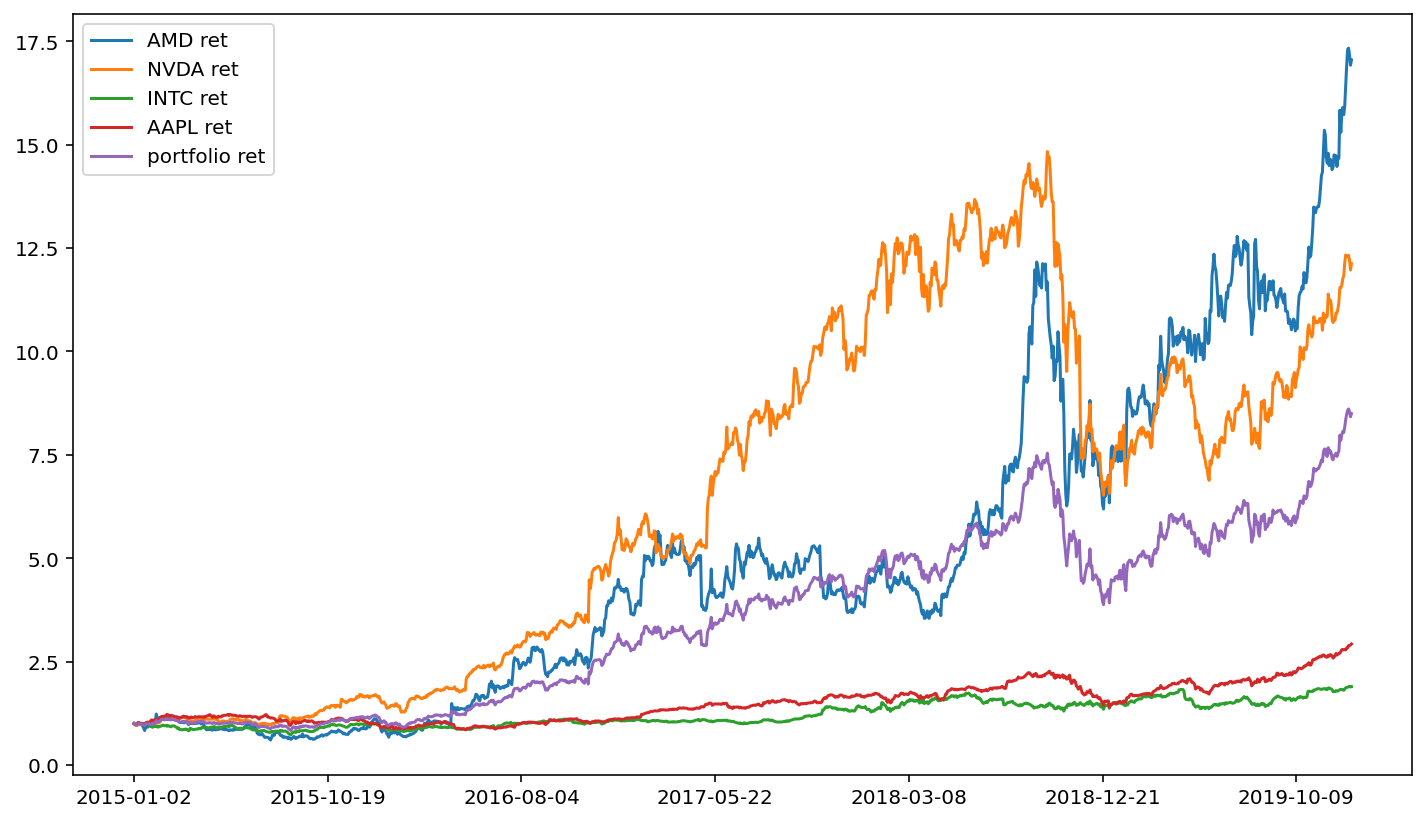

In [39]:
#ticker_list = ['VZ', 'T', 'TMUS']
ticker_list = ['AMD', 'NVDA', 'INTC', 'AAPL']

data = {}
for tic in ticker_list:
    df = web.DataReader(tic, 'av-daily-adjusted', start, end, api_key=api_key)
    df[tic + ' ret'] = df['adjusted close'] / df['adjusted close'].iloc[0]
    df = df[[tic + ' ret']].copy()
    data.update({tic: df})

df2 = data[ticker_list[0]].join([ data[m] for m in ticker_list[1:] ])
df2['portfolio ret'] = df2[[tic + ' ret' for tic in ticker_list]].sum(axis=1) / len(ticker_list)

df2.plot()

An interesting feature of the above cell block is that we only need to change the first line of code, and we can create an equal-weighted portfolio of stocks for any set of stocks that we want (note, however, that the free version of the Alpha Vantage API will limit you to loading five stocks per minute).